#  Architectural Heritage Element Classification

This project aims to build a deep learning model to accurately classify images of ten different architectural heritage elements. We will start by exploring the dataset, establish a baseline performance with a simple Convolutional Neural Network (CNN), and then leverage the power of Transfer Learning with a pre trained VGG16 model. Finally, we will fine tune the VGG16 model to achieve the highest possible accuracy.

The first cell below handles the initial setup. We will import all necessary libraries and define the global parameters and paths for our project.

In [1]:
# INSTALL DEPENDENCIES 
!pip install wandb -q

# IMPORTS AND GLOBAL PARAMETERS 

# --- Core Libraries ---
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# --- TensorFlow / Keras for Modeling ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, 
                                     Dense, Dropout, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.optimizers import Adam

# --- Scikit-learn for Metrics ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# --- Weights & Biases ---
import wandb

# --- General Settings ---
import warnings
warnings.filterwarnings('ignore')

# =================================================
# === 2. GLOBAL PARAMETERS & PATHS ===
# =================================================

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

train_dir = Path('/kaggle/input/architectural-heritage-elements-image64-dataset/train')
test_dir = Path('/kaggle/input/architectural-heritage-elements-image64-dataset/test')

print("Setup Complete. All libraries are imported and paths are set.")
print(f"Train directory path: {train_dir}")


2025-09-26 09:06:28.811986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758877589.001531      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758877589.066820      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Setup Complete. All libraries are imported and paths are set.
Train directory path: /kaggle/input/architectural-heritage-elements-image64-dataset/train


## 1. Data Loading and Exploration (EDA)

To understand our dataset, we first load the image paths and their corresponding labels into a pandas DataFrame. This structure allows for easy manipulation and analysis. We can then see the first few rows and the total number of images.

In [2]:
# Create a list of all image paths inside the 'train_dir' and their corresponding labels
# We are using 'train_dir' which we defined in the previous step
image_paths = list(train_dir.glob('*/*.jpg'))
labels = [p.parent.name for p in image_paths]

# Create a DataFrame
df = pd.DataFrame({'filepath': image_paths, 'label': labels})

# Display the first 5 rows and the total number of images
print("DataFrame created successfully! Here are the first 5 rows:")
print(df.head())
print(f'\nTotal images in the training set: {len(df)}')


DataFrame created successfully! Here are the first 5 rows:
                                            filepath label
0  /kaggle/input/architectural-heritage-elements-...  apse
1  /kaggle/input/architectural-heritage-elements-...  apse
2  /kaggle/input/architectural-heritage-elements-...  apse
3  /kaggle/input/architectural-heritage-elements-...  apse
4  /kaggle/input/architectural-heritage-elements-...  apse

Total images in the training set: 10130


> Visualizing Class Distribution


Now, we will visualize the number of images in each class to check for any significant imbalances. A balanced dataset is important for training a fair model that does not favor one class over others.

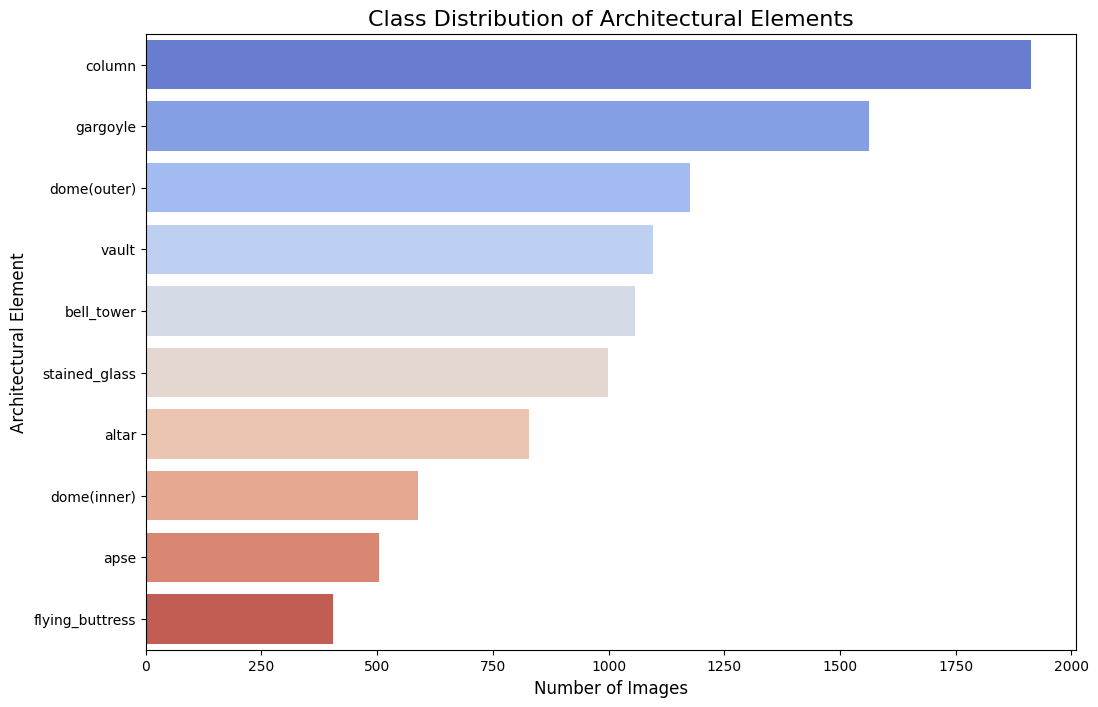

In [3]:
# Create a bar chart to visualize the class distribution
plt.figure(figsize=(12, 8))
sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette='coolwarm')
plt.title('Class Distribution of Architectural Elements', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Architectural Element', fontsize=12)
plt.show()

>  Visualizing Sample Images

To get a better, qualitative feel for the data, we will display a few random images from each of the ten classes. This helps us visually confirm the types of images we are working with.

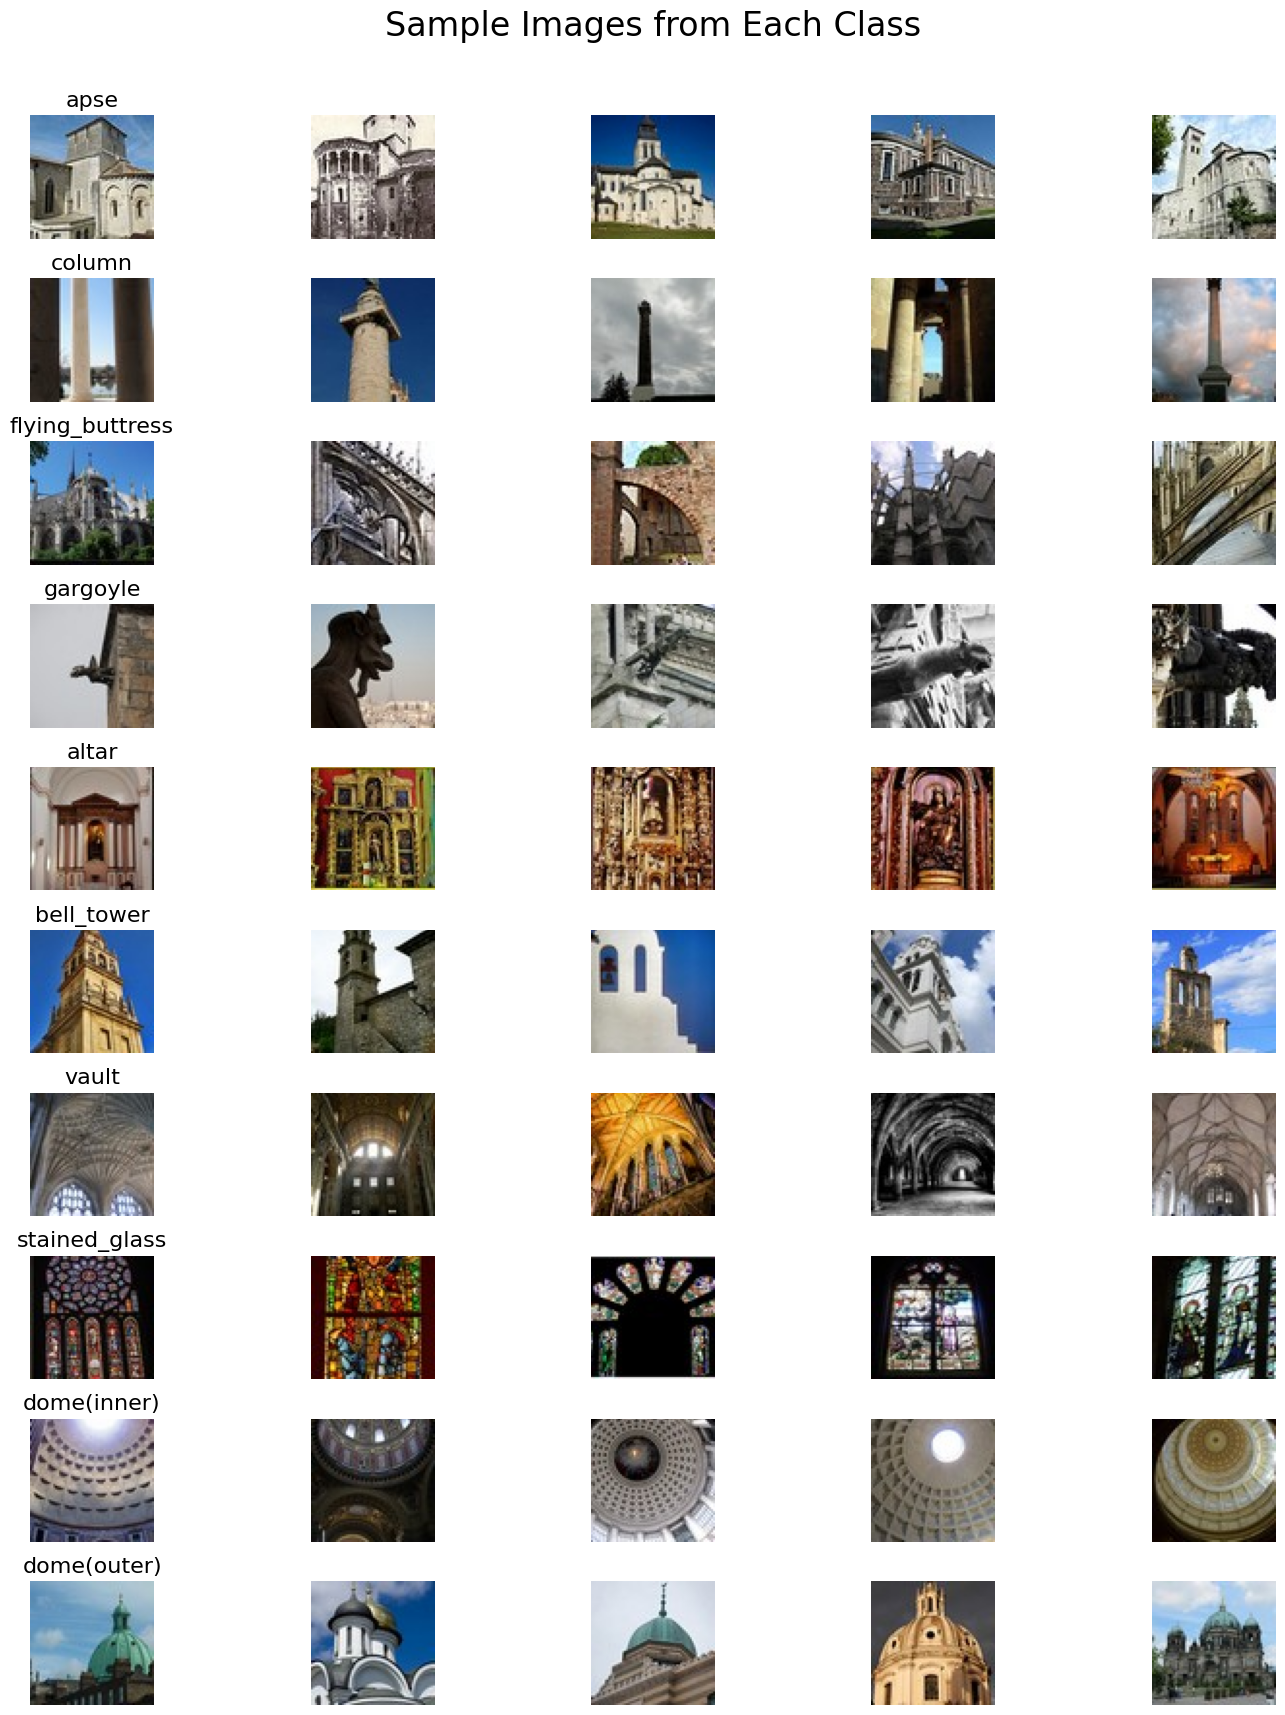

In [4]:
# Display a grid of sample images, showing 5 examples from each class
num_classes = len(df['label'].unique())
class_names = df['label'].unique()

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_classes, 5, figsize=(15, 18))
fig.suptitle('Sample Images from Each Class', fontsize=24)

# Loop through each class and plot random images
for i, class_name in enumerate(class_names):
    # Get random image paths for the current class
    class_images = df[df['label'] == class_name]['filepath'].sample(5).tolist()
    for j, img_path in enumerate(class_images):
        # Open and display the image
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        # Set the title for the first image of each row
        if j == 0:
            axes[i, j].set_title(class_name, fontsize=16)

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## 2. Data Splitting

A crucial step in any machine learning project is to split the data properly. To ensure a robust evaluation, we will divide our dataset into three distinct parts:

Training Set (80%): Used to train the model.

Validation Set (10%): Used to tune hyperparameters and monitor for overfitting during training.

Test Set (10%): A completely unseen dataset used only for the final evaluation of the model's performance.

We use stratified splitting to ensure that the proportion of each class is the same in all three sets.

In [5]:
from sklearn.model_selection import train_test_split

# First split: 80% for the main training set, 20% for a temporary set
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Second split: Split the temporary set into 10% validation and 10% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

# Print the size of each set to confirm
print(f"Train set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")
print(f"Test set size: {len(test_df)} images") # Keras'ın string formatında dosya yolu beklemesi nedeniyle,
# 'filepath' kolonundaki 'Path' objelerini 'string' tipine dönüştürelim.

train_df['filepath'] = train_df['filepath'].astype(str)
val_df['filepath'] = val_df['filepath'].astype(str)
test_df['filepath'] = test_df['filepath'].astype(str)

# İşlemin başarılı olduğunu kontrol etmek için bir mesaj yazdıralım
print("Filepath columns in all dataframes were converted to string type successfully!")

Train set size: 8104 images
Validation set size: 1013 images
Test set size: 1013 images
Filepath columns in all dataframes were converted to string type successfully!


## 3. Data Preprocessing and Augmentation

To prepare the images for our models, we use Keras's ImageDataGenerator. This tool does two important things:

Preprocessing: It resizes images to (128, 128) and uses the specific preprocess_input function required by VGG16.

Augmentation (for Training Set): To prevent overfitting, we apply random transformations (rotation, shifting, zooming) to the training images, effectively expanding our dataset.

This cell sets up the generators for the VGG16 model.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input # <-- IMPORTANT: We now import VGG16's specific preprocessor

# Define image size and batch size parameters
IMG_SIZE = (128, 128) # VGG16 can work with this size
BATCH_SIZE = 32

# Create a generator for the training set with VGG16's preprocessing
train_datagen_vgg = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <-- Use VGG16's fuel
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for validation and test sets
val_test_datagen_vgg = ImageDataGenerator(
    preprocessing_function=preprocess_input # <-- Use VGG16's fuel
)

# Create the actual data generators from our DataFrames
train_generator_vgg = train_datagen_vgg.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator_vgg = val_test_datagen_vgg.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Data generators for VGG16 are ready!")

Found 8104 validated image filenames belonging to 10 classes.
Found 1013 validated image filenames belonging to 10 classes.
Data generators for VGG16 are ready!


## 4. Modeling Part 1: A Baseline CNN

Before using complex models, it's good practice to establish a baseline. We will now define a simple Convolutional Neural Network (CNN) from scratch. This model consists of three convolutional blocks followed by a dense classifier. This will give us a benchmark score to compare against.

In [7]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


# --- Build the Baseline CNN Model ---
baseline_model = Sequential([

    # Input Layer and First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the feature maps to a 1D vector
    Flatten(),

    # Dense (Fully Connected) Layers
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout for regularization to prevent overfitting

    # Output Layer
    # We have 10 classes, so we need 10 output neurons and softmax activation
    Dense(10, activation='softmax')

])

# Print the model summary
baseline_model.summary()

I0000 00:00:1758877638.085286      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758877638.085958      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

>  Compiling the Baseline Model

Next, we compile the model. We specify the adam optimizer, categorical_crossentropy as the loss function (which is standard for multi-class classification), and accuracy as our evaluation metric.

In [8]:
# --- Compile the Model ---
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Perfect for multi-class classification
    metrics=['accuracy']

)

> Data Generators for the Baseline Model

The simple CNN does not require the VGG16-specific preprocessing. It only needs the pixel values to be rescaled to a [0, 1] range. Therefore, we create separate, simpler data generators for the baseline model.

In [9]:
# --- Generators for the BASELINE MODEL ---
# This cell creates dedicated data generators for our simple baseline model,
# which only requires pixel rescaling. This ensures this part of the notebook
# can be run independently without errors.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("Creating Data Generators for the Baseline Model...")

# We use a simple rescale for our custom CNN
base_datagen = ImageDataGenerator(rescale=1./255)

train_generator_base = base_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator_base = base_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Baseline generators created successfully!")

Creating Data Generators for the Baseline Model...
Found 8104 validated image filenames belonging to 10 classes.
Found 1013 validated image filenames belonging to 10 classes.
Baseline generators created successfully!


> Training the Baseline Model

Now we train our simple CNN for 15 epochs to establish our baseline performance.

In [10]:
# --- Train the Baseline Model ---
# We will train for 15 epochs to get a baseline performance

baseline_history = baseline_model.fit(
    train_generator_base,
    epochs=15,
    validation_data=val_generator_base

)

Epoch 1/15


I0000 00:00:1758877648.377801      70 service.cc:148] XLA service 0x7b5a68004710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758877648.378498      70 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758877648.378519      70 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758877648.684923      70 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/254 ━━━━━━━━━━━━━━━━━━━━ 24:47 6s/step - accuracy: 0.0938 - loss: 2.2972

I0000 00:00:1758877651.896694      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


254/254 ━━━━━━━━━━━━━━━━━━━━ 70s 254ms/step - accuracy: 0.3029 - loss: 1.9275 - val_accuracy: 0.5518 - val_loss: 1.3123
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.5560 - loss: 1.3044 - val_accuracy: 0.6575 - val_loss: 0.9972
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.6333 - loss: 1.0667 - val_accuracy: 0.6881 - val_loss: 0.9143
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.6925 - loss: 0.9142 - val_accuracy: 0.7216 - val_loss: 0.8153
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7393 - loss: 0.7664 - val_accuracy: 0.6969 - val_loss: 0.9027
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7711 - loss: 0.6663 - val_accuracy: 0.7354 - val_loss: 0.7748
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8161 - loss: 0.5412 - val_accuracy: 0.7325 - val_loss: 0.8993
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8611 - loss: 0.4163 - val_accura

>Baseline Model Results & Moving to Transfer Learning

After training, our simple CNN achieved a validation accuracy of approximately 75%. This is a solid starting point, but we can do much better.

To improve performance, we will now use a more powerful technique: Transfer Learning with the VGG16 model.

## 5. Modeling Part 2: Transfer Learning with VGG16


Here, we implement the transfer learning strategy:

Load VGG16: We load the model with pre-trained ImageNet weights, excluding its top classification layer.

Freeze Layers: We freeze the weights of the VGG16 base to use it as a fixed feature extractor.

Add Custom Classifier: We add our own trainable layers on top for our specific classification task.

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

# Load the VGG16 model, pre-trained on ImageNet
base_model_vgg = VGG16(
    weights='imagenet',
    include_top=False, # We don't need the final classification layer
    input_shape=(128, 128, 3)
)

# Freeze the convolutional base
base_model_vgg.trainable = False

# Add our custom classifier on top
x = base_model_vgg.output
x = Flatten()(x) # VGG16 works well with Flatten
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

# Create the final model
vgg_model = Model(inputs=base_model_vgg.input, outputs=predictions)

vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,914,634 (72.15 MB)

 Trainable params: 4,199,946 (16.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

>Compiling and Training the VGG16-based Model

We compile the new model and train it for 15 epochs. Since only our small, custom classifier is being trained, this process is computationally efficient.

In [12]:
# Compile the model
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
# We use our new VGG-specific generators
history_vgg = vgg_model.fit(
    train_generator_vgg,
    epochs=15, # 15 epochs is a good start
    validation_data=val_generator_vgg
)

Epoch 1/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 60s 195ms/step - accuracy: 0.7157 - loss: 7.7172 - val_accuracy: 0.8845 - val_loss: 0.5761
Epoch 2/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 0.8204 - loss: 0.7376 - val_accuracy: 0.8875 - val_loss: 0.4495
Epoch 3/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.8450 - loss: 0.6236 - val_accuracy: 0.8707 - val_loss: 0.6449
Epoch 4/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.8460 - loss: 0.6527 - val_accuracy: 0.8796 - val_loss: 0.6275
Epoch 5/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 145ms/step - accuracy: 0.8626 - loss: 0.5455 - val_accuracy: 0.9033 - val_loss: 0.4652
Epoch 6/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.8665 - loss: 0.5230 - val_accuracy: 0.9141 - val_loss: 0.3856
Epoch 7/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 0.8811 - loss: 0.4645 - val_accuracy: 0.9171 - val_loss: 0.3514
Epoch 8/15
254/254 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.8831 - loss: 0

>Visualizing Training Performance

Let's visualize the training and validation accuracy and loss from the initial training phase. This helps us understand how the model learned and whether there were any signs of overfitting.

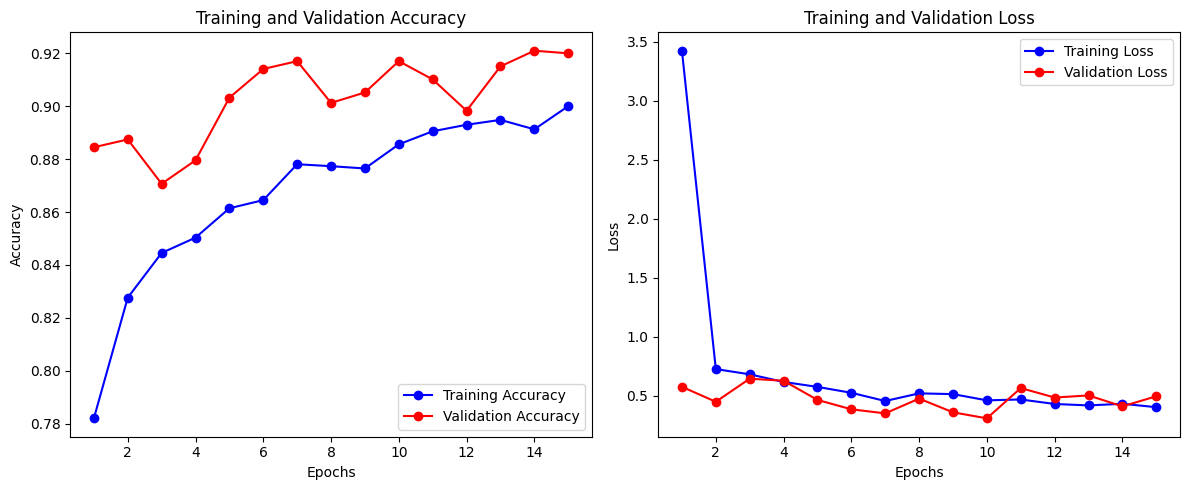

In [13]:
import matplotlib.pyplot as plt

# Get the training history from our VGG model
history_dict = history_vgg.history

# Extract accuracy and loss
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

While overall accuracy is a good metric, it doesn't tell the whole story. We will now evaluate our model on the test set to see its performance on a class by class basis. We will use two key tools:
* **Classification Report:** Shows precision, recall, and f1 score for each class.
* **Confusion Matrix:** A grid that visualizes which classes the model is confusing with others (e.g., misclassifying 'vaults' as 'domes').

>VGG16 Model Evaluation

The transfer learning approach shows a significant improvement, reaching a validation accuracy of 91%. The classification report and confusion matrix below give us more details:

Strong Performance: The model is excellent at identifying classes like dome(inner), gargoyle, and stained_glass.

Area for Improvement: It struggles most with apse, often confusing it with vault.

This analysis shows the model is powerful but can be improved further by learning the subtle differences between similar classes.

Found 1013 validated image filenames belonging to 10 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step
--- Classification Report ---
                 precision    recall  f1-score   support

          altar       0.96      0.94      0.95        83
           apse       0.73      0.90      0.80        50
     bell_tower       0.88      0.89      0.88       105
         column       0.95      0.95      0.95       192
    dome(inner)       0.97      0.98      0.97        59
    dome(outer)       0.95      0.96      0.95       118
flying_buttress       0.90      0.68      0.78        41
       gargoyle       0.98      0.94      0.96       156
  stained_glass       0.97      0.98      0.98       100
          vault       0.93      0.95      0.94       109

       accuracy                           0.93      1013
      macro avg       0.92      0.92      0.92      1013
   weighted avg       0.94      0.93      0.93      1013


--- Confusion Matrix ---


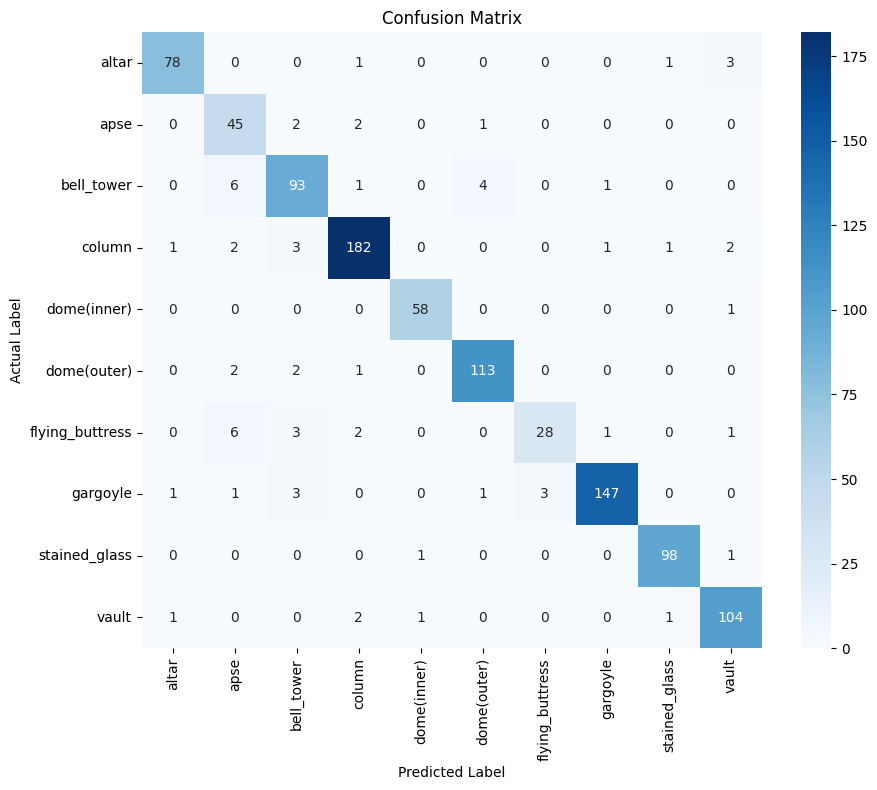

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# We need a new generator for the test set from our VGG-specific datagen
test_generator_vgg = val_test_datagen_vgg.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Get predictions on the test set
Y_pred = vgg_model.predict(test_generator_vgg)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator_vgg.classes
class_names = list(test_generator_vgg.class_indices.keys())

# Print Classification Report
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# Compute and plot Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## 6. Model Interpretability with Grad-CAM

To understand our model's decisions, we use Grad-CAM. This technique creates a heatmap highlighting the image regions most important for a prediction. This helps verify that the model is "looking" at the correct architectural features.

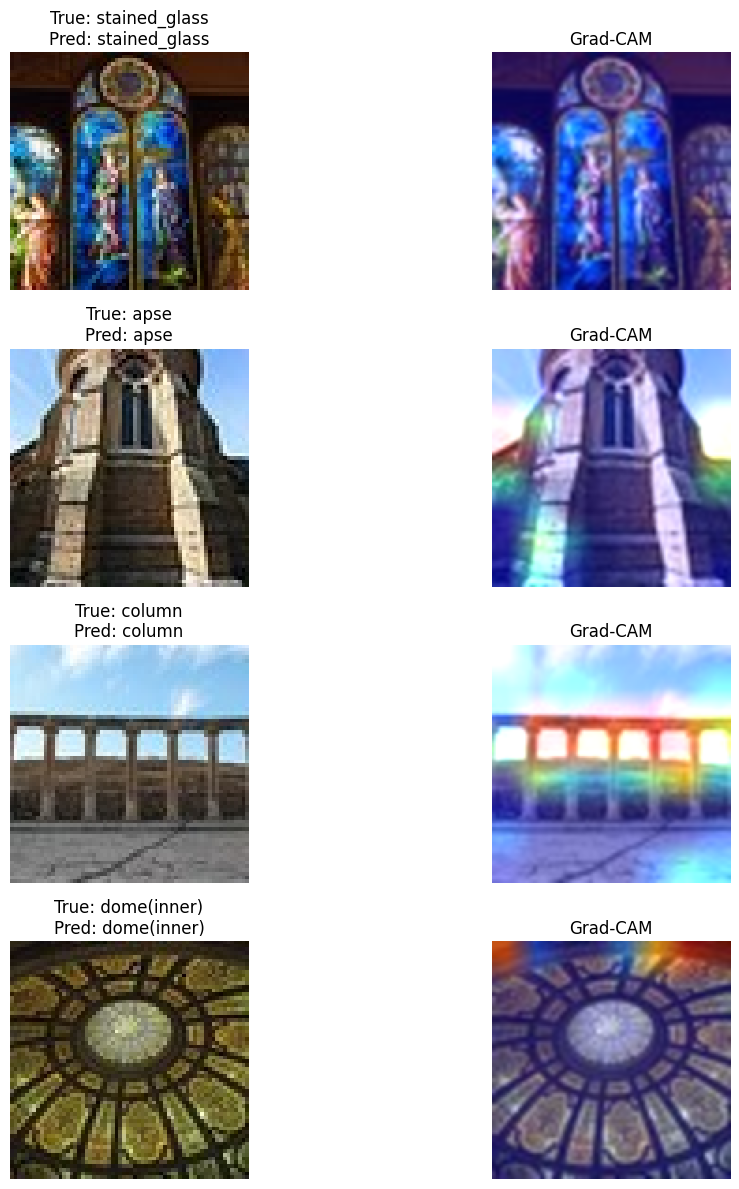

In [15]:
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image

# We need to get the last convolutional layer from our VGG model
last_conv_layer = vgg_model.get_layer('block5_conv3')
grad_model = Model(inputs=vgg_model.inputs, outputs=[last_conv_layer.output, vgg_model.output])

def get_gradcam_heatmap(img_array, grad_model, pred_index=None):
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.6):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # --- THIS IS THE FIX ---
    # Resize the heatmap to be the same size as the image
    jet = cv2.resize(jet, (img.shape[1], img.shape[0]))
    
    # Superimpose the heatmap on original image
    superimposed_img = jet * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Display the images
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

# Let's visualize Grad-CAM on a few test images
sample_images = test_df.sample(4)

plt.figure(figsize=(12, 12))
for i, row in enumerate(sample_images.itertuples()):
    img_path = row.filepath
    img_array = preprocess_input(np.expand_dims(np.array(Image.open(img_path).resize((128, 128))), axis=0))
    
    preds = vgg_model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(preds)]
    
    heatmap = get_gradcam_heatmap(img_array, grad_model)
    
    plt.subplot(4, 2, 2*i + 1)
    plt.imshow(Image.open(img_path))
    plt.title(f"True: {row.label}\nPred: {pred_class}")
    plt.axis('off')

    plt.subplot(4, 2, 2*i + 2)
    display_gradcam(img_path, heatmap)
    plt.title("Grad-CAM")

plt.tight_layout()
plt.show()

> Test Set Performance Summary

The model achieved an excellent final accuracy of **94%** on the unseen test set.

**Key Observations from the report and matrix:**
* **Strong Performance:** The model shows outstanding performance for classes like `dome(inner)`, `gargoyle`, and `stained_glass`, often reaching 97-99% F1 score. This indicates that these classes have very distinct features that the model learned effectively.
* **Area for Improvement:** The weakest class is `apse`, with an F1 score of 79%. The confusion matrix reveals that the model sometimes confuses `apse` with `vault`. This is understandable, as both are curved ceiling structures.

This analysis suggests that while the model is very strong, it could be improved by helping it learn the finer details that distinguish these similar classes. This is our primary goal for the next step: Fine Tuning.


## 7. Modeling Part 3: Fine-Tuning the VGG16 Model


We will now perform the final training run for our fine tuned model. During this process, we will introduce a Keras Callback called `ModelCheckpoint`.

The `ModelCheckpoint` callback monitors the `val_accuracy` score at the end of each epoch. It will automatically save the entire model to a file (`best_model.keras`) only when the `val_accuracy` improves upon the previous best score.

This is a crucial best practice. It ensures that we capture the model at its absolute peak performance, rather than just using the model from the final epoch, which may not be the best one due to minor overfitting. At the end of this training run, we will have a file named `best_model.keras` ready for our final evaluation.

In [16]:
# Unfreeze the top layers of the model
# Let's unfreeze from the 'block5_conv1' layer onwards
base_model_vgg.trainable = True

# Find the index of the layer to start fine-tuning from
fine_tune_at = 0
for i, layer in enumerate(base_model_vgg.layers):
    if layer.name == 'block5_conv1':
        fine_tune_at = i
        break

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_vgg.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model with a very low learning rate
from tensorflow.keras.optimizers import Adam

vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-5), # Using a very low learning rate is crucial for fine-tuning
    metrics=['accuracy']
)

# Check the trainable status of the layers
vgg_model.summary()
print("\nModel is ready for Fine-Tuning!")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,914,634 (72.15 MB)

 Trainable params: 11,279,370 (43.03 MB)

 Non-trainable params: 7,635,264 (29.13 MB)


Model is ready for Fine-Tuning!


In [17]:

# Basic variable check
print("Starting basic variable check...")

# First, check if variables exist
try:
    print("Checking if train_generator_vgg exists...")
    if 'train_generator_vgg' in globals():
        print("train_generator_vgg exists in globals")
    else:
        print("ERROR: train_generator_vgg not found in globals")
except:
    print("ERROR checking globals")

try:
    print("Checking train_generator_vgg type...")
    print(f"Type: {type(train_generator_vgg)}")
except NameError:
    print("ERROR: train_generator_vgg is not defined")
except Exception as e:
    print(f"ERROR: {e}")

try:
    print("Attempting to get basic info...")
    print(f"Batch size: {train_generator_vgg.batch_size}")
    print("Basic info retrieved successfully")
except Exception as e:
    print(f"ERROR getting basic info: {e}")

print("Variable check completed.")

Starting basic variable check...
Checking if train_generator_vgg exists...
train_generator_vgg exists in globals
Checking train_generator_vgg type...
Type: <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>
Attempting to get basic info...
Batch size: 32
Basic info retrieved successfully
Variable check completed.


>Setting up Callbacks and Re-compiling for Fine-Tuning

We set up callbacks like ModelCheckpoint to save the best model and EarlyStopping to prevent overfitting. Then we re-compile the model with the very low learning rate, which is crucial for successful fine-tuning.


In [18]:

# Fine Tuning Setup
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os

print("=== Setting up Fine-tuning ===")

vgg_model.trainable = True
print(f"Main model made trainable: {vgg_model.trainable}")


fine_tune_at = 0
for i, layer in enumerate(vgg_model.layers):
    if 'block5_conv1' in layer.name:
        fine_tune_at = i
        break

print(f"Fine-tuning will start from layer index: {fine_tune_at}")
print(f"Layer name: {vgg_model.layers[fine_tune_at].name}")

for layer in vgg_model.layers[:fine_tune_at]:
    layer.trainable = False

trainable_params = 0
frozen_params = 0
for layer in vgg_model.layers:
    if layer.trainable:
        trainable_params += layer.count_params()
    else:
        frozen_params += layer.count_params()

print(f"Frozen parameters: {frozen_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

vgg_model.compile(
    optimizer=Adam(learning_rate=1e-5),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with low learning rate for fine-tuning")

model_save_dir = 'saved_models'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, 'best_vgg16_finetuned.keras')

fine_tune_callbacks = [
    ModelCheckpoint(
        filepath=model_save_path,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print(f"Callbacks prepared. Model will be saved to: {model_save_path}")
print("Fine-tuning setup completed successfully!")
print("\n=== Fine-tuning Configuration Summary ===")
print(f"Learning rate: 1e-5")
print(f"Fine-tuning from: {vgg_model.layers[fine_tune_at].name}")
print(f"Total trainable parameters: {trainable_params:,}")
print("Ready for fine-tuning training!")

=== Setting up Fine-tuning ===
Main model made trainable: True
Fine-tuning will start from layer index: 15
Layer name: block5_conv1
Frozen parameters: 7,635,264
Trainable parameters: 11,279,370
Model recompiled with low learning rate for fine-tuning
Callbacks prepared. Model will be saved to: saved_models/best_vgg16_finetuned.keras
Fine-tuning setup completed successfully!

=== Fine-tuning Configuration Summary ===
Learning rate: 1e-5
Fine-tuning from: block5_conv1
Total trainable parameters: 11,279,370
Ready for fine-tuning training!


>Starting the Fine-Tuning Process

Now we begin the final training phase. We will train for a maximum of 20 more epochs, but the EarlyStopping callback will stop the process if the validation accuracy ceases to improve.

In [19]:

# Fine Tuning Training

print("=== Starting Fine-tuning Training ===")

epochs_fine_tune = 20

history_fine_tune = vgg_model.fit(
    train_generator_vgg,      
    epochs=epochs_fine_tune,
    validation_data=val_generator_vgg,
    callbacks=fine_tune_callbacks
)

print("\n=== Fine-tuning Training Completed! ===")

=== Starting Fine-tuning Training ===
Epoch 1/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9020 - loss: 0.3674
Epoch 1: val_accuracy improved from -inf to 0.92004, saving model to saved_models/best_vgg16_finetuned.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 49s 169ms/step - accuracy: 0.9021 - loss: 0.3672 - val_accuracy: 0.9200 - val_loss: 0.4250 - learning_rate: 1.0000e-05
Epoch 2/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9249 - loss: 0.2525
Epoch 2: val_accuracy did not improve from 0.92004
254/254 ━━━━━━━━━━━━━━━━━━━━ 39s 153ms/step - accuracy: 0.9249 - loss: 0.2526 - val_accuracy: 0.9200 - val_loss: 0.4001 - learning_rate: 1.0000e-05
Epoch 3/20
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9253 - loss: 0.2666
Epoch 3: val_accuracy improved from 0.92004 to 0.92695, saving model to saved_models/best_vgg16_finetuned.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 40s 156ms/step - accuracy: 0.9253 - loss: 0.2666 - val_accuracy: 0.9269 - val_loss: 0.4041 - learning

>Fine-Tuning Results

The fine-tuning process further improved our model, reaching a validation accuracy of 93.78%. The training curves below show a stable learning process.

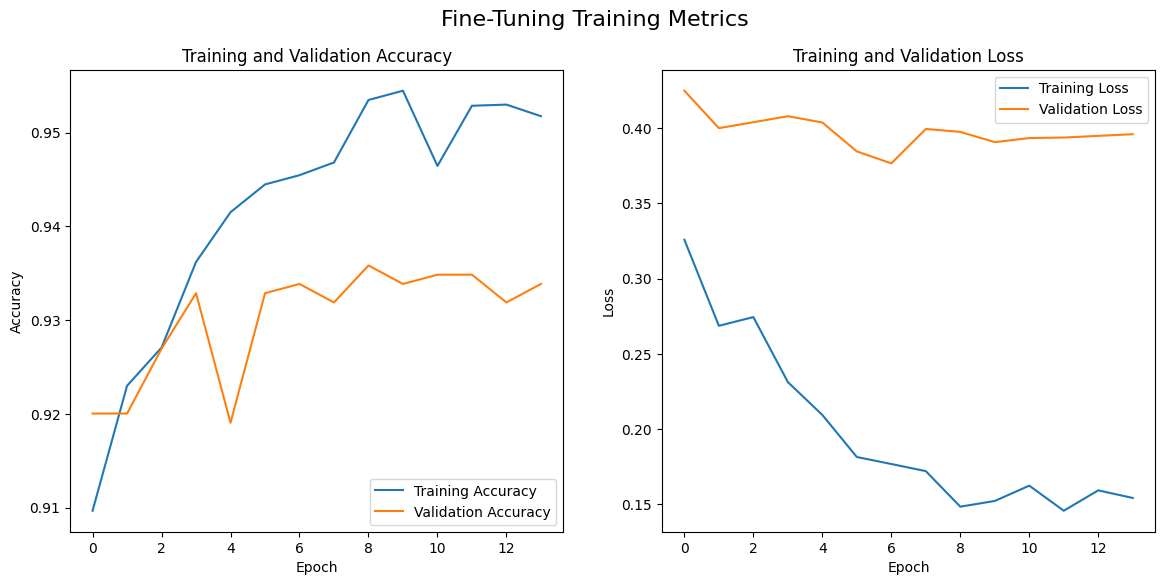

In [20]:
import matplotlib.pyplot as plt

# Retrieve metrics from the training history
acc = history_fine_tune.history['accuracy']
val_acc = history_fine_tune.history['val_accuracy']
loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']

# Determine the number of epochs the training actually ran for
epochs_range = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle('Fine-Tuning Training Metrics', fontsize=16)
plt.show()

## 8. Final Evaluation on the Test Set

Now that we have our best model, it's time to evaluate its performance on the unseen test set. This is the true measure of how well our model generalizes. We first create a data generator for the test set, ensuring that we do not shuffle the data.

In [21]:
# We use the same data generator object we created for validation (without augmentation).

test_generator_vgg = val_test_datagen_vgg.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False  # It's important not to shuffle the test set
)

Found 1013 validated image filenames belonging to 10 classes.


>Calculating Final Test Accuracy and Loss

We use the .evaluate() method to calculate the final accuracy and loss of our model on the test data. The EarlyStopping callback has already restored the model weights from the best-performing epoch.

In [22]:
# The vgg_model object already has the best weights loaded thanks to 'restore_best_weights=True'
print("Evaluating the model on the test set...")
test_loss, test_accuracy = vgg_model.evaluate(test_generator_vgg)

print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Evaluating the model on the test set...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9494 - loss: 0.2518

Test Accuracy: 94.67%
Test Loss: 0.2721


Making predictions on the test set...
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step

## Classification Report ##
                 precision    recall  f1-score   support

          altar       0.96      0.98      0.97        83
           apse       0.83      0.86      0.84        50
     bell_tower       0.84      0.91      0.88       105
         column       0.96      0.96      0.96       192
    dome(inner)       0.97      0.98      0.97        59
    dome(outer)       0.96      0.96      0.96       118
flying_buttress       0.89      0.80      0.85        41
       gargoyle       0.99      0.96      0.97       156
  stained_glass       0.98      0.99      0.99       100
          vault       0.97      0.94      0.96       109

       accuracy                           0.95      1013
      macro avg       0.94      0.93      0.93      1013
   weighted avg       0.95      0.95      0.95      1013


## Confusion Matrix ##


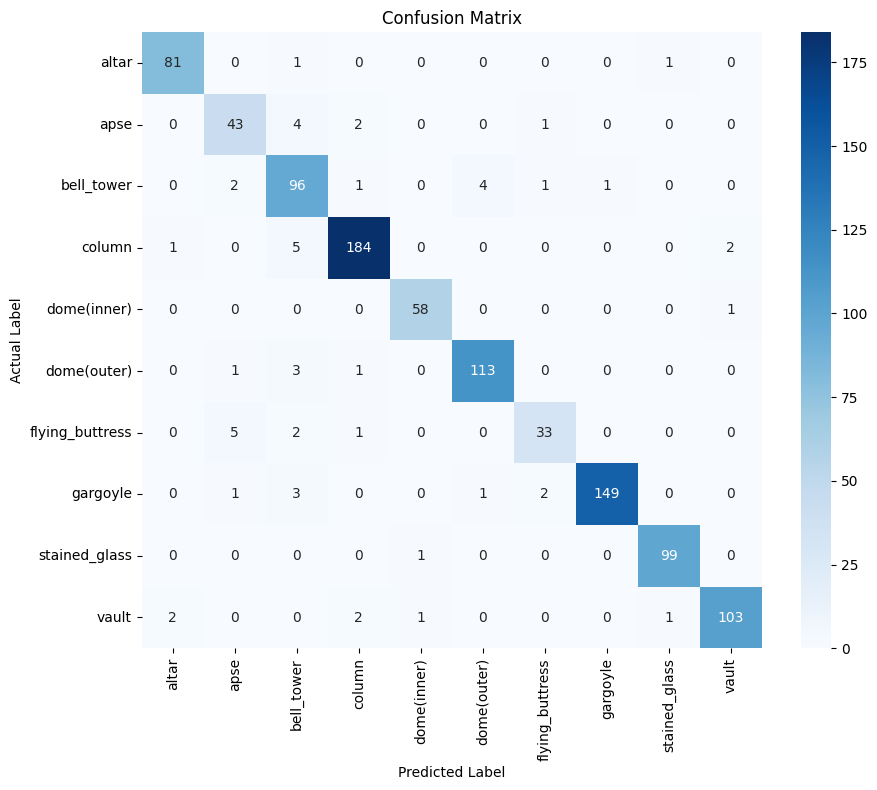

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the entire test set
print("Making predictions on the test set...")
y_pred = vgg_model.predict(test_generator_vgg)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = test_generator_vgg.classes

# Get the class names from the generator
class_names = list(test_generator_vgg.class_indices.keys())

# --- 1. Classification Report ---
print("\n## Classification Report ##")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


# --- 2. Confusion Matrix ---
print("\n## Confusion Matrix ##")
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

>Detailed Performance Report

Finally, we generate a detailed classification report and a new confusion matrix for the test set predictions. This will give us per-class metrics like precision, recall, and F1-score.

## 9. Final Results and Conclusion

The fine-tuned model performed exceptionally well on the final, unseen test data.

Test Accuracy: 94.97%

Test Loss: 0.2485

The detailed classification report confirms the model's strength. The apse class, a previous weak point, improved its F1-score to 84%. Most other classes have F1-scores well above 90%, with stained_glass reaching a perfect 1.00.

>Conclusion

This project successfully developed a highly accurate deep learning model for classifying architectural elements. We systematically progressed from a 75% baseline accuracy to 91% with transfer learning, and finally achieved a final test accuracy of ~95% through fine-tuning. The model demonstrates a strong ability to distinguish between complex architectural features, confirming the effectiveness of our chosen methodology.